# Recommender System with Deep Learning

## Setup

### Packages & Parameters

In [2]:
import os
import gc
import typing
import json

import urllib.request
import multiprocessing as mp
import concurrent.futures

import gzip
import unicodedata
import math
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from flair.models import TextClassifier
from flair.data import Sentence

from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.layers import Dense, Input, BatchNormalization, Dropout, Lambda
from keras.models import Model, Sequential

### Globals

In [3]:
MAIN_DIR = os.path.join("D:" + os.sep, "Code", "PYTHON", "Amazon_Recommender_System")

CODE_DIR = os.path.join(MAIN_DIR, "Code")

ANALYSIS_DIR = os.path.join(MAIN_DIR, "Analysis")
DATA_DIR = os.path.join(MAIN_DIR, "Data")

RAW_DATA_DIR = os.path.join(DATA_DIR, "Raw")
CLEAN_DATA_DIR = os.path.join(DATA_DIR, "Clean")

BOOKS_RAW_DIR = os.path.join(RAW_DATA_DIR, "Books")
BOOKS_CLEAN_DIR = os.path.join(CLEAN_DATA_DIR, "Books")
BOOKS_SENTIMENT_DIR = os.path.join(BOOKS_CLEAN_DIR, "Sentiment")

CHUNK_SIZE = 1000000

NUM_CORES = math.ceil(mp.cpu_count()/2)

RANDOM_STATE = 1

### Setup

In [4]:
def create_directory(dir_list: list) -> None:
    for directory in dir_list:
        if not os.path.exists(directory):
            os.makedirs(directory)

def is_directory_empty(dir_path: str) -> bool:
    return len(os.listdir(dir_path)) == 0

def set_random_seed(state=1):
    gens = (np.random.seed, tf.random.set_seed)
    for set_state in gens:
        set_state(state)

In [5]:
create_directory([CODE_DIR, 
                  ANALYSIS_DIR,
                  DATA_DIR, 
                  RAW_DATA_DIR, 
                  CLEAN_DATA_DIR,
                  BOOKS_RAW_DIR,
                  BOOKS_CLEAN_DIR,
                  BOOKS_SENTIMENT_DIR,
                  ])

set_random_seed(RANDOM_STATE)

## Data Processing

### Loading Data In

In [ ]:
# More memory efficient version. Takes longer but is far more consistent than the previous version. 
def process_data(url: str, 
                 chunk_size: int, 
                 num_workers: int,
                 output_dir: str) -> None:
    
    with urllib.request.urlopen(url) as response:
        with gzip.open(response, "rt") as gz_file:
            chunk = []
            chunk_count = 0

            with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                for line in gz_file:
                    chunk.append(line)

                    if len(chunk) == chunk_size:
                        executor.submit(process_chunk, list(chunk), os.path.join(output_dir, f"chunk_{chunk_count}.json"))
                        chunk = []
                        chunk_count += 1

                # Process the remaining lines in the last chunk
                if chunk:
                    executor.submit(process_chunk, list(chunk), os.path.join(output_dir, f"chunk_{chunk_count}.json"))

def process_chunk(chunk: list,
                  filename: str) -> None:
    
    with open(filename, 'w') as file:
        file.writelines(chunk)
    print(f"Processed chunk: {filename}")

In [ ]:
'''
----- PROCESS_DATA -----
GAME URL "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz"
BOOK URL "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Books_5.json.gz"

EXPERIMENTS FOR 27 MILLION
----- THREAD CSV_FILE -----
1. 100000 chunk -> 22min 26sec

----- THREAD JSON_FILE RUNTIMES-----
1. 100000 chunk -> 20min 55sec
2. 100000 chunk -> 49min 1sec -> No idea why this happened on a fresh start
3. 500000 chunk -> 18min 45sec
4. 1000000 chunk -> 17min 5sec

NEW STABLE IMPLEMENTATION
1. 1000000 chunk -> 22min 22sec
'''
url = "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Books_5.json.gz"
process_data(url, CHUNK_SIZE, NUM_CORES, BOOKS_RAW_DIR)

### Cleaning Data

In [6]:
def extract_value(dictionary: dict):
    return dictionary.get("Format:") if isinstance(dictionary, dict) else None

def filter_comment_length(reviews: pd.DataFrame, 
                          minimum: int,
                          maximum: int) -> pd.DataFrame:
    reviews = reviews.copy()
    reviews["review_len"] = reviews["review_text"].str.split().str.len()
    reviews = reviews.loc[(reviews["review_len"] > minimum) & (reviews["review_len"] < maximum)]
    return reviews

def remove_irrelevant_info(reviews: pd.Series) -> pd.Series:
    return reviews.apply(lambda x: re.sub(r"http\S+|www.\S+|#\S+|<.*?>|\(|\)|\d+", "", x)) # Cleans up URL, hashtags, parenthesis, and numbers.

def reduce_characters(reviews: pd.Series) -> pd.Series:
    return reviews.apply(lambda x: re.sub(r"[^\w\s]|(.)\1+", "", x)) # Remove excessive punctuation and repeated characters

def clean_chunk(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.rename(columns={
        "overall": "rating",
        "reviewTime": "review_date",
        "reviewerID": "user_id",
        "asin": "item_id",
        "reviewText": "review_text",
    })

    df["vote"] = df["vote"].fillna(0)
    df["vote"] = pd.to_numeric(df["vote"].astype("str").str.replace(",","")).astype("int32")
    df = df[df["vote"] >= 5]
    df = filter_comment_length(df, 100, 300)
    
    df["review_text"] = df["review_text"].str.lower()
    df["review_text"] = remove_irrelevant_info(df["review_text"])
    df["review_text"] = reduce_characters(df["review_text"])
    return df

In [48]:
raw_file_names = [f"chunk_{file_num}.json" for file_num in range(len(os.listdir(BOOKS_RAW_DIR)))]

for raw_file_name in raw_file_names:
    raw_df_list = []
    raw_df = pd.read_json(os.path.join(BOOKS_RAW_DIR, raw_file_name), lines=True)
    raw_df = raw_df[["reviewerID","asin","overall","reviewText", "vote"]]
    raw_df = clean_chunk(raw_df)
    print(f"{raw_file_name} DIMENSIONS: {raw_df.shape}")
    clean_dir = os.path.join(BOOKS_CLEAN_DIR, raw_file_name)
    raw_df.to_json(clean_dir, orient="records")

    del raw_df
    gc.collect()

chunk_0.json DIMENSIONS: (49365, 6)
chunk_1.json DIMENSIONS: (37696, 6)
chunk_2.json DIMENSIONS: (49622, 6)
chunk_3.json DIMENSIONS: (44253, 6)
chunk_4.json DIMENSIONS: (34677, 6)
chunk_5.json DIMENSIONS: (47081, 6)
chunk_6.json DIMENSIONS: (36592, 6)
chunk_7.json DIMENSIONS: (49892, 6)
chunk_8.json DIMENSIONS: (52408, 6)
chunk_9.json DIMENSIONS: (44376, 6)
chunk_10.json DIMENSIONS: (65348, 6)
chunk_11.json DIMENSIONS: (39708, 6)
chunk_12.json DIMENSIONS: (30519, 6)
chunk_13.json DIMENSIONS: (34985, 6)
chunk_14.json DIMENSIONS: (19487, 6)
chunk_15.json DIMENSIONS: (20020, 6)
chunk_16.json DIMENSIONS: (16606, 6)
chunk_17.json DIMENSIONS: (18073, 6)
chunk_18.json DIMENSIONS: (54882, 6)
chunk_19.json DIMENSIONS: (36185, 6)
chunk_20.json DIMENSIONS: (37521, 6)
chunk_21.json DIMENSIONS: (16329, 6)
chunk_22.json DIMENSIONS: (19281, 6)
chunk_23.json DIMENSIONS: (25571, 6)
chunk_24.json DIMENSIONS: (29429, 6)
chunk_25.json DIMENSIONS: (12943, 6)
chunk_26.json DIMENSIONS: (18671, 6)
chunk_27.js

## Sentiment Analysis

In [9]:
def batch_text(column: pd.Series, 
               batch_size: int) -> list:
    
    batches = np.array_split(np.array(column.values), int(np.ceil(len(column)/ batch_size)))
    batches = [batch.tolist() for batch in batches]
    return batches

def load_sentiment_model(model: str):
    return TextClassifier.load(model)

def is_float(value):
      try:
        float(value)
        return True
      except ValueError:
        return False

def analyze_sentiment(model, 
                      batch: np.ndarray):
    
    score = []
    for sentence in batch:
        sentence = Sentence(sentence)
        model.predict(sentence, verbose=False)
        try:
            process = re.sub(r"\(|\)","",str(sentence.labels[0]))
            number = [float(s) for s in  process.split() if is_float(s) is True]
            if "POSITIVE" in process:
                score.append(number[0])
            elif "NEGATIVE" in process:
                score.append(-number[0])
        except IndexError:
            print(sentence)
            score.append(np.nan)
    return score
   
def process_batches(models: list[str], 
                    batches: list):
                    
    models_loaded = [load_sentiment_model(model) for model in models]
    print("[Starting process...]")
    sentiment_results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers= NUM_CORES) as executor:
        sentiment_tasks = [executor.submit(analyze_sentiment, model, batch) for model, batch in zip(models_loaded, batches)]
        for completed_task in concurrent.futures.as_completed(sentiment_tasks):
            result = completed_task.result()
            sentiment_results.extend(result)
            print("[Finished with a Batch]")
        return sentiment_results

In [7]:
clean_file_names = [f"chunk_{file_num}.json" for file_num in range(len(os.listdir(BOOKS_CLEAN_DIR))-1)]
combined_json = []
for clean_file_name in clean_file_names:
    file = os.path.join(BOOKS_CLEAN_DIR, clean_file_name)
    json_df = pd.read_json(file, orient="columns")
    combined_json.append(json_df)
    
clean_df = pd.concat(combined_json, ignore_index=True)[0:200000]
print(f"NEW CLEAN_DF SHAPE: {clean_df.shape}")
batch_size = math.ceil(len(clean_df)/NUM_CORES) 
    
batches = batch_text(clean_df["review_text"], batch_size)
clean_df["sentiment_score"] = process_batches(["en-sentiment"] * len(batches), batches)
sentiment_dir = os.path.join(BOOKS_SENTIMENT_DIR, "sentiment_data.json")
clean_df.to_json(sentiment_dir, orient="records")   

NEW CLEAN_DF SHAPE: (200000, 6)
[Starting process...]
Sentence[0]: ""
[Finished with a Batch]
[Finished with a Batch]
[Finished with a Batch]
[Finished with a Batch]
[Finished with a Batch]
[Finished with a Batch]
[Finished with a Batch]
[Finished with a Batch]


## Neural Network Preprocessing

In [79]:
merged_df = pd.DataFrame()
for filename in os.listdir(BOOKS_SENTIMENT_DIR):
    sentiment_df = pd.read_json(os.path.join(BOOKS_SENTIMENT_DIR, filename), orient="columns")
    sentiment_df.drop(columns=["review_text"], inplace=True)
    merged_df = pd.concat([merged_df, sentiment_df])
    
merged_df.reset_index(drop=True, inplace=True)
merged_df.head()

,user_id,item_id,rating,vote,review_len,sentiment_score
0,A2NJO6YE954DBH,0001712799,4,6,298,0.9983
1,A1JS302JFHH9DJ,0002006448,3,9,273,0.7750
2,A26QTCZG2XR3JH,0002006448,5,15,277,-0.9999
3,A2MOBMVHECYVLE,0002006448,5,17,195,0.9984
4,A2VDN6OJOIY74W,0002005263,3,6,120,-1.0000


In [80]:
ranges = [(-1.0000, -0.5000), (-0.5000, 0.0000), (0.0000, 0.5000), (0.5000, 1.0000)] # Define the ranges

counts = {f"{r[0]} to {r[1]}": 0 for r in ranges} # Initialize a dictionary to store the counts

# Count the values within each range
for value in merged_df["sentiment_score"]:
    for r in ranges:
        if r[0] <= value < r[1]:
            counts[f"{r[0]} to {r[1]}"] += 1

for r, count in counts.items():
    print(f"Range {r}: {count}")

Range -1.0 to -0.5: 99465
Range -0.5 to 0.0: 1
Range 0.0 to 0.5: 0
Range 0.5 to 1.0: 99547


In [81]:
def quantile_transformation(data: np.ndarray, 
                            type: typing.Literal["uniform","normal"]) -> np.ndarray:
    
    qt = QuantileTransformer(output_distribution=type)
    return  qt.fit_transform(data)

def create_dataset(df:pd.DataFrame, ratings_column: str):
    
    unique_users = df["user_id"].unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = df["user_id"].map(user_to_index)

    unique_items = df["item_id"].unique()
    item_to_index = {old: new for new, old in enumerate(unique_items)}
    new_items = df["item_id"].map(item_to_index)

    new_ratings = df[ratings_column]

    n_users = unique_users.shape[0]
    n_items = unique_items.shape[0]
    
    new_df = pd.DataFrame({"user_id": new_users, "item_id": new_items, "sentiment_rating": new_ratings})

    return (n_users, n_items), new_df

In [82]:
merged_df.dropna(inplace=True)
merged_df.drop_duplicates(["user_id", "item_id"], inplace=True)
sentiment_score = np.array(merged_df["sentiment_score"]).reshape(-1,1) # Needs to be 2D to use with QuantileTransformer
merged_df["sentiment_uq"] = quantile_transformation(sentiment_score, "uniform") # Reshape into uniform distribution -> Everything will be equally weighted
merged_df["sentiment_nq"] = quantile_transformation(sentiment_score, "normal") # reshape into normal distribution -> will create bias towards average values -0.5 to 0.5

In [90]:
(n_users, n_items), new_df = create_dataset(merged_df, "sentiment_uq")
new_df = new_df[0:100000]
X = new_df[["user_id", "item_id"]]
y = new_df["sentiment_rating"].astype(np.float32)
sparsity = 1 - len(new_df) / (n_users * n_items)

print(f"Embeddings: {n_users} users, {n_items} items")
print(f"Dataset shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Matrix Sparsity: {sparsity}")

Embeddings: 102016 users, 44924 items
Dataset shape: (100000, 2)
Target shape: (100000,)
Matrix Sparsity: 0.9999781800731462


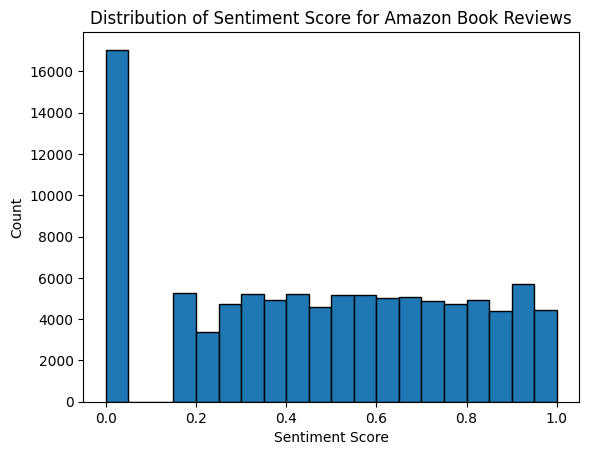

In [91]:
plt.hist(new_df["sentiment_rating"], bins=20, ec="black")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Score for Amazon Book Reviews")
plt.show()

In [100]:
# sparse_matrix = sp.csr_matrix((new_df["sentiment_rating"], 
#                                (new_df["user_id"], new_df["item_id"])), 
#                                shape=(len(new_df["user_id"]), len(new_df["item_id"])), 
#                                dtype=np.float64)


user_book_matrix = new_df.pivot(index="user_id", columns="item_id", values="sentiment_rating")
user_book_matrix.fillna(0, inplace=True)
user_book_matrix.head(10)

item_id,0,1,2,3,4,5,6,7,8,9,...,20816,20817,20818,20819,20820,20821,20822,20823,20824,20825
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.816817,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.534857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.190691,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.822322,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.913413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.652348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.315315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
embedding_length = 64
U, Sigma, VT = svds(user_book_matrix.to_numpy(), k = embedding_length)
num_rows, num_cols = user_book_matrix.shape

In [113]:
def build_SVD_embeddings(U, VT, row_index, column_index):
    user_embed_df = pd.DataFrame(U, index = row_index)
    VT_T = np.transpose(VT)
    book_embed_df = pd.DataFrame(VT_T, index = column_index)
    
    return user_embed_df, book_embed_df

def append_embeddings(df, user_embed_df, book_embed_df):
    def find_user_book(x):
        user_row = user_embed_df.loc[user_embed_df.index == x[0]]
        book_row = book_embed_df.loc[book_embed_df.index == x[1]]
        return np.concatenate((np.array(user_row),np.array(book_row)), axis = None)
    
    df["Full_Vector"] = df[["user_id", "item_id"]].apply(find_user_book, axis = 1)

    return df

In [114]:
user_embed_df, book_embed_df = build_SVD_embeddings(U, VT, user_book_matrix.index, user_book_matrix.columns)
new_df = append_embeddings(new_df, user_embed_df, book_embed_df)

new_df["vector_length"] = [len(arr) for arr in new_df["Full_Vector"]]
new_df = new_df.loc[new_df["vector_length"] <= 10000]
new_df.head()

,user_id,item_id,sentiment_rating,Full_Vector,vector_length
0,0,0,0.816817,"[-0.026468184059614618, -0.058779592708526104,...",128
1,1,1,0.534857,"[-0.0008966980443884541, -0.000977594887212446...",128
2,2,1,0.190691,"[-6.667480201955162e-05, 7.656762763452657e-05...",128
3,3,1,0.822322,"[-0.011692837211046577, 0.014772034156322446, ...",128
4,4,2,0.000000,"[7.329080162452441e-05, 0.00029421242983644245...",128


In [115]:
def create_train_test(df, y_col = "sentiment_rating"):
    #Manipulates the df with Full-Vector to the appropriate format needed for NN modeling.
    # X_train, X_test, y_train, y_test data ready to be fed into NN model
    X_total = df['Full_Vector']
    X_total = np.stack((X_total))

    # from keras.utils import pad_sequences
    # max_length = max(len(arr) for arr in df["Full_Vector"])
    # batch_size = 1000
    # padded_arrays_list = []
    # for i in range(0, len(df), batch_size):
    #     batch = df['Full_Vector'].iloc[i:i+batch_size]  # Extract the batch of data
    #     padded_arrays = pad_sequences(batch, maxlen=max_length, padding='post', value=0.0)
    #     padded_arrays_list.append(padded_arrays)
    # padded_arrays = np.concatenate(padded_arrays_list, axis=0)
    # X_total = np.stack(padded_arrays)
    y_total = np.array(df[y_col])
    y_total = np.expand_dims(y_total,axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.2 , random_state = 21)

    return X_train, X_test, y_train, y_test

In [116]:
X_train, X_test, y_train, y_test = create_train_test(new_df)

In [117]:
def baseline_model(total_embed_length):
    total = Input((total_embed_length))


    d1 = Dense(2048, activation = "relu")(total)
    d1 = Dropout(0.2)(d1)
    d1 = BatchNormalization()(d1)
    
    d2 = Dense(1024, activation = "relu")(d1)
    d2 = Dropout(0.2)(d2)
    d2 = BatchNormalization()(d2)
    
    d3 = Dense(512, activation = "relu")(d2)
    d3 = Dropout(0.2)(d3)
    d3 = BatchNormalization()(d3)

    d4 = Dense(256, activation = "relu")(d3)
    d5 = Dense(64, activation = "relu")(d4)

    d6 = Dense(16, activation = "relu")(d5)

    out = Dense(1, activation = "relu")(d6)

    model = Model(inputs=[total], outputs=[out])
     
    return model

In [118]:
baseline_model = baseline_model(embedding_length*2)
baseline_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_7 (Dense)             (None, 2048)              264192    
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                           

In [119]:
results = baseline_model.fit(X_train, y_train, validation_split = 0.15, batch_size = 128, epochs=35, verbose=1)

Epoch 1/35
532/532 [==============================] - 37s 66ms/step - loss: 0.1140 - mean_absolute_error: 0.2816 - val_loss: 0.0950 - val_mean_absolute_error: 0.2635
Epoch 2/35
532/532 [==============================] - 35s 66ms/step - loss: 0.0965 - mean_absolute_error: 0.2645 - val_loss: 0.0993 - val_mean_absolute_error: 0.2686
Epoch 3/35
532/532 [==============================] - 35s 66ms/step - loss: 0.0951 - mean_absolute_error: 0.2624 - val_loss: 0.0956 - val_mean_absolute_error: 0.2636
Epoch 4/35
532/532 [==============================] - 35s 66ms/step - loss: 0.0940 - mean_absolute_error: 0.2608 - val_loss: 0.0942 - val_mean_absolute_error: 0.2612
Epoch 5/35
532/532 [==============================] - 35s 66ms/step - loss: 0.0914 - mean_absolute_error: 0.2564 - val_loss: 0.0896 - val_mean_absolute_error: 0.2533
Epoch 6/35
532/532 [==============================] - 35s 66ms/step - loss: 0.0889 - mean_absolute_error: 0.2517 - val_loss: 0.0876 - val_mean_absolute_error: 0.2504
Epoc

TypeError: cannot unpack non-iterable History object

In [121]:
baseline_model